In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# read the dataset and build a preprocessor for it
df = pd.read_csv('data/diabetes_prediction_dataset.csv')
y = df['diabetes']
X = df.drop(columns=['diabetes'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=38)

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

onehot = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('onehot', onehot, categorical_columns),
    ('zscore', scaler, numerical_columns)
])

# Part1: SVC Model

In [6]:
pipe_SVC = Pipeline([
    ('make_futures', preprocessor),
    ('classifier', SVC())
])

search_space_SVC = [{'classifier__kernel': ['linear'],
                 'classifier__C': np.logspace(-3, 2, 11)
                },
                {'classifier__kernel': ['poly'],
                 'classifier__gamma': np.logspace(-3, 1, 8),
                 'classifier__degree': range(2,6),
                 'classifier__C': np.logspace(-3, 1, 8)
                },
                {'classifier__kernel': ['rbf'],
                 'classifier__gamma': np.logspace(-3, 1, 9),
                 'classifier__C': np.logspace(-3, 1, 9)
                }]

best_model_SVC = GridSearchCV(pipe_SVC, search_space_SVC, cv=5, verbose=1)

train_data = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
down_sampled = pd.concat([train_data[train_data['diabetes'] == 1].sample(n=3000, random_state=38), train_data[train_data['diabetes'] == 0].sample(n=7000, random_state=38)]).sample(frac=1, random_state=38)

y_train_down_sampled = down_sampled['diabetes']
X_train_down_sampled = down_sampled.drop(columns=['diabetes'])

X_train_1000 = X_train_down_sampled[:1000]
y_train_1000 = y_train_down_sampled[:1000]

In [7]:
%time best_model_SVC.fit(X_train_1000, y_train_1000)
y_pred = best_model_SVC.predict(X_test)
df_SVC = pd.DataFrame({'label': y_test, 'predict_1000':y_pred})

Fitting 5 folds for each of 348 candidates, totalling 1740 fits
CPU times: total: 2min 29s
Wall time: 2min 29s


In [128]:
print('best_params:', best_model_SVC.best_params_)

best_params: {'classifier__C': 3.1622776601683795, 'classifier__gamma': 0.03162277660168379, 'classifier__kernel': 'rbf'}


In [129]:
model_SVC_best_param = pipe_SVC.set_params(**best_model_SVC.best_params_)
model_SVC_best_param.fit(X_train_down_sampled, y_train_down_sampled)
y_pred = model_SVC_best_param.predict(X_test)
df_SVC['predict_10000'] = y_pred

In [130]:
report = {
    'accuracy': accuracy_score(df_SVC['label'], df_SVC['predict_10000']),
    'recall': recall_score(df_SVC['label'], df_SVC['predict_10000']),
    'f1': f1_score(df_SVC['label'], df_SVC['predict_10000'])
}
report

{'accuracy': 0.9417, 'recall': 0.7880133185349611, 'f1': 0.7089365951073389}

In [133]:
df_SVC.to_csv('data/SVC_predict.csv')

# Part2: KNN Model

In [7]:
pipe_KNN = Pipeline([
    ('make_futures', preprocessor),
    ('classifier', KNN())
])

X_train_knn, X_valid_knn, y_train_knn, y_valid_knn = train_test_split(X_train, y_train, test_size=0.2, random_state=38)

In [8]:
scores = pd.DataFrame({'f1_score': [], 'accuracy_score': [], 'recall_score': []})
for k in np.logspace(0, 2.5, 10):
    curr_model = pipe_KNN.set_params(classifier__n_neighbors=int(k))
    
    curr_model.fit(X_train_knn, y_train_knn)
    y_pred = curr_model.predict(X_valid_knn)
    scores.loc[int(k), 'f1_score'] = f1_score(y_valid_knn, y_pred)
    scores.loc[int(k), 'accuracy_score'] = accuracy_score(y_valid_knn, y_pred)
    scores.loc[int(k), 'recall_score'] = recall_score(y_valid_knn, y_pred)

In [9]:
best_k = scores['accuracy_score'].idxmax()
best_k

12

In [10]:
best_model_knn = pipe_KNN.set_params(classifier__n_neighbors=best_k)
best_model_knn.fit(X_train, y_train)
y_pred = best_model_knn.predict(X_test)

df_knn = pd.DataFrame()
df_knn['label'] = y_test
df_knn['predict'] = y_pred

In [11]:
df_knn

,label,predict
81721,0,0
83672,0,0
60485,0,0
16700,0,0
80068,1,1
...,...,...
608,0,0
36427,0,0
96489,0,0
37703,0,0


In [12]:
report = {
    'k': best_k,
    'accuracy': accuracy_score(df_knn['label'], df_knn['predict']),
    'recall': recall_score(df_knn['label'], df_knn['predict']),
    'f1': f1_score(df_knn['label'], df_knn['predict'])
}
report

{'k': 12,
 'accuracy': 0.9613,
 'recall': 0.5971143174250833,
 'f1': 0.7354750512645251}

In [13]:
df_knn.to_csv('data/KNN_predict.csv')

# Part3: Decision Tree Model

In [19]:
pipe_DT = Pipeline([('make_features', preprocessor),  # Use your preprocessor
    ('classifier', DecisionTreeClassifier())  # Use a decision tree classifier
])

X_train_DT, X_valid_DT, y_train_DT, y_valid_DT = train_test_split(X_train, y_train, test_size=0.2, random_state=38)

In [24]:
hyperparameters = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 7,10,12,15,18,20,50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5]
}

DT = GridSearchCV(pipe_DT, param_grid=hyperparameters, cv=5,verbose=1)

train_data = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
down_sampled = pd.concat([train_data[train_data['diabetes'] == 1].sample(n=3000, random_state=38), train_data[train_data['diabetes'] == 0].sample(n=7000, random_state=38)]).sample(frac=1, random_state=38)

y_train_down_sampled = down_sampled['diabetes']
X_train_down_sampled = down_sampled.drop(columns=['diabetes'])

X_train_1000 = X_train_down_sampled[:1000]
y_train_1000 = y_train_down_sampled[:1000]
#grid.fit(X_train_DT, y_train_DT)

In [25]:
%timeit DT.fit(X_train_1000, y_train_1000)
y_pred = DT.predict(X_test)
df_DT = pd.DataFrame({'label': y_test, 'predict_1000':y_pred})

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
6.41 s ± 65.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
print("Best parameters: ", DT.best_params_)
y_pred = DT.predict(X_test)
df_DT = pd.DataFrame({'label': y_test, 'predict_1000':y_pred})

Best parameters:  {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}


In [29]:
model_DT_best_param = pipe_DT.set_params(**DT.best_params_)
model_DT_best_param.fit(X_train_down_sampled, y_train_down_sampled)
y_pred = model_DT_best_param.predict(X_test)
df_DT['predict_10000'] = y_pred

In [31]:
report = {
    'accuracy': accuracy_score(df_DT['label'], df_DT['predict_10000']),
    'recall': recall_score(df_DT['label'], df_DT['predict_10000']),
    'f1': f1_score(df_DT['label'], df_DT['predict_10000'])
}
report

{'accuracy': 0.9463, 'recall': 0.806881243063263, 'f1': 0.730286288297338}

In [32]:
df_DT.to_csv('data/DT_predict.csv')

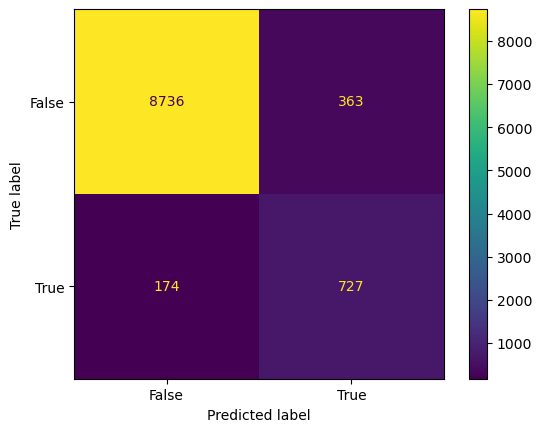

In [33]:
cm = confusion_matrix(df_DT['label'], df_DT['predict_10000'])
plt = ConfusionMatrixDisplay(cm, display_labels=['False', 'True']).plot()

# Part4: Boosting  Model

In [14]:
pipe_boost = Pipeline([
    ('make_futures', preprocessor),
    ('boost', GradientBoostingClassifier())
])

search_space_boost = {
        "boost__loss":["deviance"],
        "boost__learning_rate": [0.0001, 0.001, 0.01, 0.1],
        "boost__min_samples_split": np.linspace(0.1, 0.5, 6),
        "boost__min_samples_leaf": np.linspace(0.1, 0.5, 6),
        "boost__max_depth":[3,6,9],
        "boost__max_features":["log2","sqrt"],
        "boost__n_estimators":[10]
    }

best_model_boost = GridSearchCV(pipe_boost, search_space_boost, cv=5, verbose=1)

train_data = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
down_sampled = pd.concat([train_data[train_data['diabetes'] == 1].sample(n=3000, random_state=38), train_data[train_data['diabetes'] == 0].sample(n=7000, random_state=38)]).sample(frac=1, random_state=38)

y_train_down_sampled = down_sampled['diabetes']
X_train_down_sampled = down_sampled.drop(columns=['diabetes'])

X_train_1000 = X_train_down_sampled[:1000]
y_train_1000 = y_train_down_sampled[:1000]

In [16]:
%timeit best_model_boost.fit(X_train_1000, y_train_1000)
y_pred = best_model_boost.predict(X_test)
df_boost = pd.DataFrame({'label': y_test, 'predict_1000':y_pred})

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
59.4 s ± 2.53 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
best_param_boost = best_model_boost.best_params_
best_param_boost

{'boost__learning_rate': 0.1,
 'boost__loss': 'deviance',
 'boost__max_depth': 9,
 'boost__max_features': 'sqrt',
 'boost__min_samples_leaf': 0.1,
 'boost__min_samples_split': 0.18,
 'boost__n_estimators': 10}

In [19]:
model_boost_best = pipe_boost.set_params(**best_param_boost)
model_boost_best.fit(X_train_down_sampled, y_train_down_sampled)
y_pred = model_boost_best.predict(X_test)
df_boost['predict_10000'] = y_pred

In [20]:
report = {
    'accuracy': accuracy_score(df_boost['label'], df_boost['predict_10000']),
    'recall': recall_score(df_boost['label'], df_boost['predict_10000']),
    'f1': f1_score(df_boost['label'], df_boost['predict_10000'])
}
report

{'accuracy': 0.9473, 'recall': 0.43951165371809103, 'f1': 0.6004548900682335}

In [21]:
df_boost.to_csv('data/boost_predict.csv')

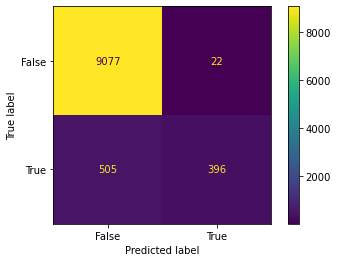

In [29]:
cm = confusion_matrix(df_boost['label'], df_boost['predict_10000'])
plt = ConfusionMatrixDisplay(cm, display_labels=['False', 'True']).plot()